In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer, PowerTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif, chi2, f_classif
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, make_scorer
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.neighbors import KNeighborsClassifier


# Načítanie dát

V predchádzajúcej fáze sme zistili, že dôležité dáta sú len v tabuľkách connections a processes. Nedáva teda zmysel znova pracovať so všetkými dátami. Načítame teda len connections and processes a vytvoríme pre ne novú pipeline.

In [3]:
connections = pd.read_csv('data/081/connections.csv', on_bad_lines='warn', delimiter='\t')
processes = pd.read_csv('data/081/processes.csv', on_bad_lines='warn', delimiter='\t')

In [4]:
data = pd.merge(connections, processes, on=['mwra', 'imei', 'ts'])

In [5]:
data = data.drop(columns=['ts', 'imei'])

In [6]:
X = data.drop(columns='mwra')
y = data['mwra']

Teraz si vytvoríme pipeline na predspracovanie naších dát.

Definujeme, si ktoré stĺpce pripomínajú normálnu distribúciu.

In [7]:
normal = ['c.android.youtube', 'c.android.chrome', 'c.android.gm', 'c.dogalize', 'c.katana', 'c.UCMobile.x86', 
          'c.updateassist', 'p.android.packageinstaller', 'p.android.documentsui', 'p.system', 'p.android.externalstorage', 
          'p.android.chrome', 'p.android.settings', 'p.android.gm', 'p.inputmethod.latin', 'p.process.gapps', 'p.notifier',]

non_normal = ['c.android.vending', 'c.UCMobile.intl', 'c.raider', 'p.android.vending', 'p.katana', 'p.google', 
              'p.android.defcontainer', 'p.simulator', 'p.android.gms', 'p.dogalize', 
              'p.gms.persistent', 'p.browser.provider', 'p.olauncher']


Zdroj: https://stackoverflow.com/questions/52346725/can-i-add-outlier-detection-and-removal-to-scikit-learn-pipeline

In [8]:
class OutlierRemover(TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self

    def transform(self, X): 
        X = X.copy()
        
        if self.columns is None:
            self.columns = X.columns
        
        for col in self.columns:
            if col not in X.columns:
                continue
            
            Q3 = X[col].quantile(0.75)
            Q1 = X[col].quantile(0.25)
            IQR = Q3 - Q1
            
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            X[col] = X[col].clip(lower=lower_bound, upper=upper_bound)
        
        return X

    def fit(self, *args, **kwargs):
        return self

In [9]:
normal_preprocessor = Pipeline(steps=[
    ("power_transformer", PowerTransformer(method='yeo-johnson', standardize=True)),
    ("scaler", StandardScaler())]
)
non_normal_preprocessor = Pipeline(steps=[
    ("quantile", QuantileTransformer(output_distribution='normal', random_state=0, n_quantiles=1000)    ),
    ("scaler", StandardScaler())]
)

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ("normal", normal_preprocessor, normal),
        ("non_normal", non_normal_preprocessor, non_normal),
    ]
)

In [11]:
preprocessing_pipeline = Pipeline(steps=[
    ('outlier_remover', OutlierRemover()),
    ('preprocessor', preprocessor),
])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 3.1

## 3.1 A
V tejto časti naiplmenetujeme jednoduchý id3 klasifikátor. Použijeme atribút max_depth rovnajúci sa 4, keďže sme túto hodnotu považovali ako rozumný tradeoff.

In [13]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif


class ID3Classifier:
    # Constructor
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    # Fit the model
    def fit(self, X, y):
        y = np.array(y, dtype=int)  # Ensure y is a numpy array of integers
        data = pd.DataFrame(X)
        data['label'] = y
        self.tree = self._build_tree(data, depth=0)
    
    # Entropy calculation
    def _entropy(self, y):
        counts = np.bincount(y)
        probabilities = counts / len(y)
        return -np.sum([p * np.log2(p) for p in probabilities if p > 0])
    
    # Information gain calculation
    def _information_gain(self, data, feature, label):
        total_entropy = self._entropy(data[label])
        values, counts = np.unique(data[feature], return_counts=True)
        weighted_entropy = np.sum([(counts[i] / np.sum(counts)) * self._entropy(data.where(data[feature] == values[i]).dropna()[label]) for i in range(len(values))])
        return total_entropy - weighted_entropy
    
    # Best feature selection
    def _best_feature(self, data, label):
        features = data.columns.drop(label)
        information_gains = [self._information_gain(data, feature, label) for feature in features]
        return features[np.argmax(information_gains)]
    
    # Build the tree
    def _build_tree(self, data, depth):
        label = 'label'
        if len(np.unique(data[label])) == 1:
            return np.unique(data[label])[0]
        elif len(data.columns) == 1 or (self.max_depth and depth >= self.max_depth):
            return data[label].mode()[0]
        else:
            best_feature = self._best_feature(data, label)
            tree = {best_feature: {}}
            for value in np.unique(data[best_feature]):
                subtree = self._build_tree(data.where(data[best_feature] == value).dropna().drop(columns=[best_feature]), depth + 1)
                tree[best_feature][value] = subtree
            return tree
        

    # Prediction
    def _predict_instance(self, instance, tree):
        if not isinstance(tree, dict):
            return tree
        feature = list(tree.keys())[0]
        if instance[feature] in tree[feature]:
            return self._predict_instance(instance, tree[feature][instance[feature]])
        else:
            # Return the most common class if the feature value is unknown
            return self._most_common_class(tree)
        
    # Most common class
    def _most_common_class(self, tree):
        # Flatten the tree and find the most common class
        classes = []
        def traverse(t):
            if isinstance(t, dict):
                for key in t:
                    traverse(t[key])
            else:
                classes.append(t)
        traverse(tree)
        return max(set(classes), key=classes.count)
    
    # Predict the class labels for the provided data
    def predict(self, X):
        data = pd.DataFrame(X)
        return data.apply(lambda x: self._predict_instance(x, self.tree), axis=1).values

class CustomID3Classifier(BaseEstimator, ClassifierMixin):
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.model = ID3Classifier(max_depth=max_depth)
    
    def fit(self, X, y):
        self.model.fit(X, y)
        return self
    
    def predict(self, X):
        return self.model.predict(X)
    
    def score(self, X, y):
        return accuracy_score(y, self.predict(X))

Upravíme pipeline a ultimátne nafitujeme na tréningové dáta:

In [14]:
"""
model_pipeline = Pipeline(steps=[
    ('feature_selection', SelectKBest(score_func=f_classif, k=4)),
    ('classifier', CustomID3Classifier(max_depth=4))
])

final_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing_pipeline),
    ('classifier', model_pipeline)
])

# Fit the pipeline to the training data
final_pipeline.fit(X_train, y_train)
"""

"\nmodel_pipeline = Pipeline(steps=[\n    ('feature_selection', SelectKBest(score_func=f_classif, k=4)),\n    ('classifier', CustomID3Classifier(max_depth=4))\n])\n\nfinal_pipeline = Pipeline(steps=[\n    ('preprocessing', preprocessing_pipeline),\n    ('classifier', model_pipeline)\n])\n\n# Fit the pipeline to the training data\nfinal_pipeline.fit(X_train, y_train)\n"

## 3.1 B

Zistíme metriky accuracy, precision a recall. Funkcie na tieto metriky sme importovali z knižnice sklearn.metrics a použili na našom vlastnom klasifikátore:

In [15]:
"""# Evaluate the model on the test data
y_test_pred = final_pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')

print(f'Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')"""

"# Evaluate the model on the test data\ny_test_pred = final_pipeline.predict(X_test)\ntest_accuracy = accuracy_score(y_test, y_test_pred)\ntest_precision = precision_score(y_test, y_test_pred, average='weighted')\ntest_recall = recall_score(y_test, y_test_pred, average='weighted')\n\nprint(f'Test Accuracy: {test_accuracy}')\nprint(f'Test Precision: {test_precision}')\nprint(f'Test Recall: {test_recall}')"

## 3.1 C

Vzhľadom na to, že tréningové metriky sú pochopiteľné rovné 1 a tieto sú rovné podstatne menším číslam, tak môžeme so silným presvedčením konštatovať, že daný model overfittuje, čo je aj od klasifikátora ID3 predpokladateľné.

# 3.2

## 3.2 A

Ako stromový algoritmus použijeme Random Forest.

In [16]:
RF_pipeline = Pipeline(steps=[
    ('feature_selection', SelectKBest(score_func=f_classif, k=10)),
    ('classifier', RandomForestClassifier(criterion='entropy', max_depth=3, random_state=0))
])

final_RF_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing_pipeline),
    ('classifier', RF_pipeline)
])

In [17]:
final_RF_pipeline.fit(X_train, y_train)
y_pred = final_RF_pipeline.predict(X_test)
y_pred_train = final_RF_pipeline.predict(X_train)

random_forest = final_RF_pipeline.named_steps['classifier'].named_steps['classifier']

selected_features = preprocessing_pipeline.named_steps['preprocessor']  # Preprocessor step
selected_feature_indices = final_RF_pipeline.named_steps['classifier'].named_steps['feature_selection'].get_support(indices=True)
selected_feature_names = X_train.columns[selected_feature_indices]

test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)

train_accuracy = accuracy_score(y_train, y_pred_train)
train_precision = precision_score(y_train, y_pred_train)
train_recall = recall_score(y_train, y_pred_train)

print(f'Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}\n')
print("\nClassification Report:\n", classification_report(y_test, y_pred))

print(f'Train Accuracy: {train_accuracy}')
print(f'Train Precision: {train_precision}')
print(f'Train Recall: {train_recall}')

Test Accuracy: 0.8859903381642512
Test Precision: 0.8825831702544031
Test Recall: 0.940563086548488


Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.80      0.84      1187
         1.0       0.88      0.94      0.91      1918

    accuracy                           0.89      3105
   macro avg       0.89      0.87      0.88      3105
weighted avg       0.89      0.89      0.88      3105

Train Accuracy: 0.8890231134734637
Train Precision: 0.8911829001700268
Train Recall: 0.9383631713554987


## 3.2 B

In [18]:
LR_pipeline = Pipeline(steps=[
    ('feature_selection', SelectKBest(score_func=f_classif, k=15)),
    ('classifier', LogisticRegression())
])

final_LR_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing_pipeline),
    ('classifier', LR_pipeline)
])

In [19]:
final_LR_pipeline.fit(X_train, y_train)
y_pred = final_LR_pipeline.predict(X_test)
y_pred_train = final_LR_pipeline.predict(X_train)

test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)

train_accuracy = accuracy_score(y_train, y_pred_train)
train_precision = precision_score(y_train, y_pred_train)
train_recall = recall_score(y_train, y_pred_train)

print(f'Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}\n')

print("\nClassification Report:\n", classification_report(y_test, y_pred))

print(f'Train Accuracy: {train_accuracy}')
print(f'Train Precision: {train_precision}')
print(f'Train Recall: {train_recall}')

Test Accuracy: 0.8921095008051529
Test Precision: 0.9011657374556513
Test Recall: 0.927007299270073


Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.84      0.86      1187
         1.0       0.90      0.93      0.91      1918

    accuracy                           0.89      3105
   macro avg       0.89      0.88      0.88      3105
weighted avg       0.89      0.89      0.89      3105

Train Accuracy: 0.8994120963195619
Train Precision: 0.9097144282329468
Train Recall: 0.9328644501278772


Vidíme, že nestromový algoritmus, konkrétne logistická regresia je viac stabilná keďže accuracy a precision sú oba približne 90% aj pri trénovacích ak pri testovacích dátach.

Pri stromovom algoritme je pri trénovacích dátach accuracy a precision 91% a pre testovacích 89%.

Takto vieme povedať, že oba algoritmy nie su overfit-nuté, ale nestromový je o trochu lepší.

## 3.2 C

Vidíme, že modely použité z knižnice scikit learn sú lepšie ako náš id3 klasifikátor o značným rozdielom.

Prvým dôvodom, je viditeľný z metrík. Model Random Forest A logistická regresia majú vyššiu accuracy a precision. To vyplíva aj z toho, že id3 klasifikátor je overfitnutý a modely Random Forest a logistická regresia nie su.

## 3.2 D

Keďže Random Forest používa 100 stromov, tak nebude možné ich všetky zobraziť, preto si zobrazíme len 2.

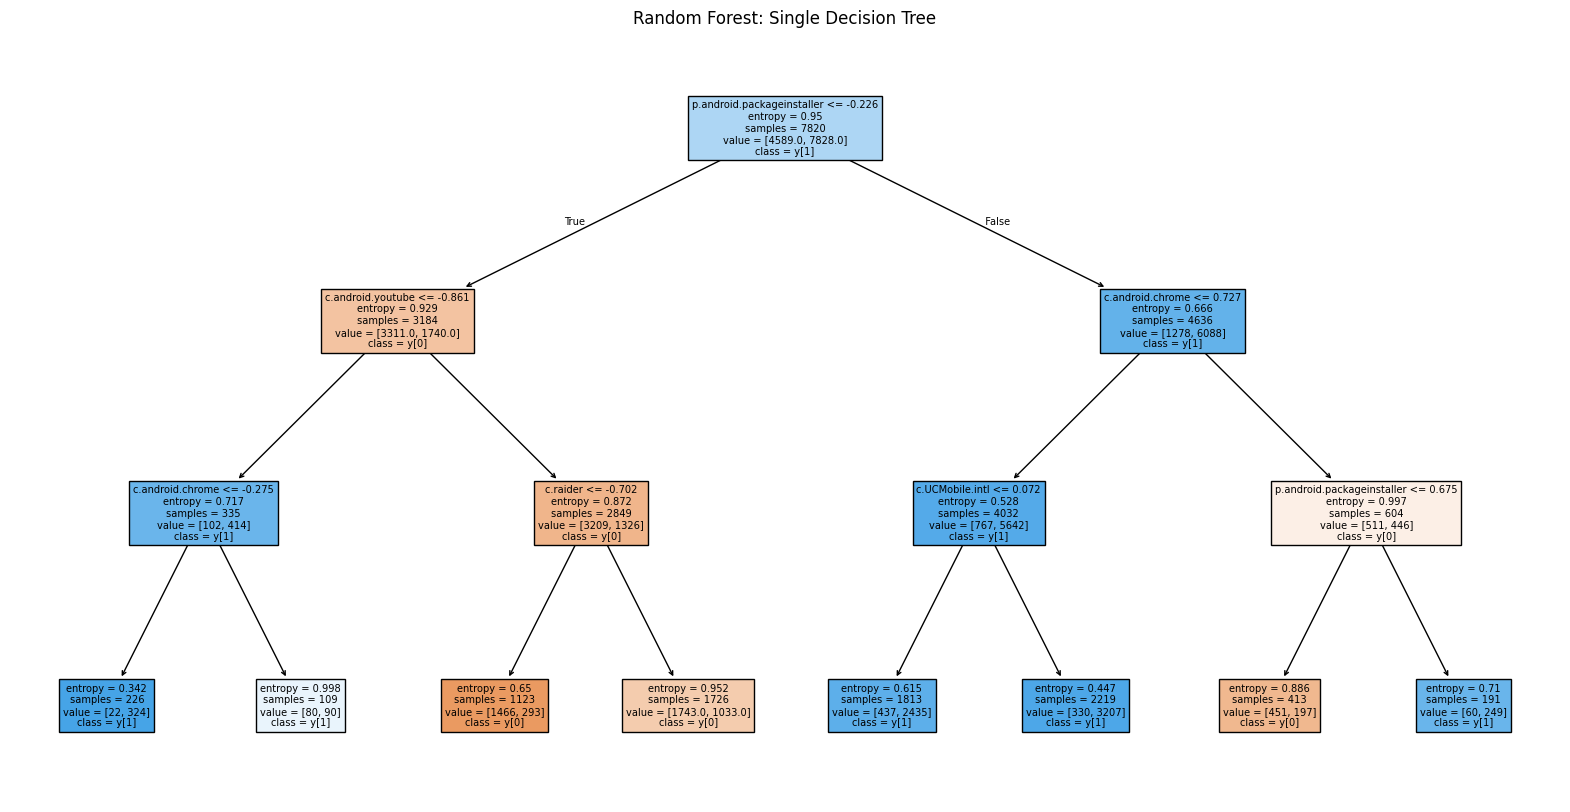

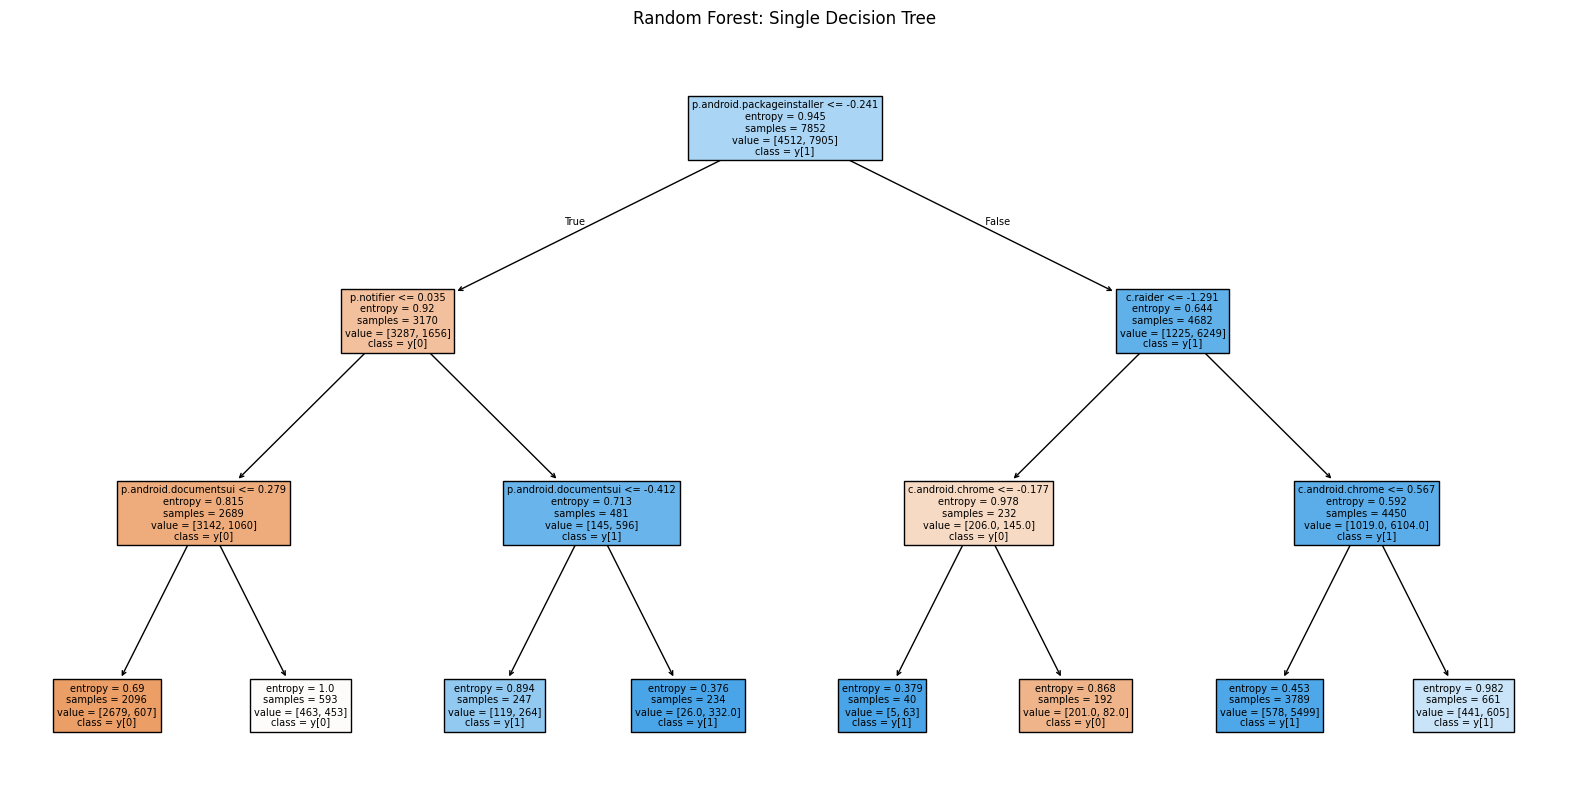

In [20]:
plt.figure(figsize=(20, 10))
plot_tree(random_forest.estimators_[0], feature_names=selected_feature_names, filled=True, class_names=True)
plt.title("Random Forest: Single Decision Tree")
plt.show()
plt.figure(figsize=(20, 10))
plot_tree(random_forest.estimators_[1], feature_names=selected_feature_names, filled=True, class_names=True)
plt.title("Random Forest: Single Decision Tree")
plt.show()

## 3.2 E

Modely sme vyhodnotili hneď po trénovani.

# 3.3

In [21]:
RF_hyperparameter_pipeline = Pipeline(steps=[
    ('feature_selection', SelectKBest()),
    ('classifier', RandomForestClassifier())
])

final_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing_pipeline),
    ('classifier', RF_hyperparameter_pipeline)
])

## 3.3 A

V tejto časti použijeme grid search na nájdenie najlepšej kombinácie hyperparametrov pre Random Forest

Zdroj: https://stackoverflow.com/questions/34624978/is-there-easy-way-to-grid-search-without-cross-validation-in-python

In [42]:
hyperparameters = {
    'classifier__feature_selection__k': [5, 10, 15],
    'classifier__classifier__n_estimators': [100, 200, 300],
    'classifier__classifier__max_depth': [8, 9, 10],
    'classifier__classifier__min_samples_split': [2, 3, 5],
    'classifier__classifier__min_samples_leaf': [1, 2, 4]
}
best_score = 0
best_grid = None
for g in ParameterGrid(hyperparameters):
    final_pipeline.set_params(**g)
    final_pipeline.fit(X_train,y_train)
    y_pred = final_pipeline.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    if acc > best_score:
        best_score = acc
        best_grid = g
        
print(best_grid)

KeyboardInterrupt: 

In [ ]:
final_pipeline.set_params(**best_grid)
final_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('outlier_remover',
                                  <__main__.OutlierRemover object at 0x0000020B962A4350>),
                                 ('preprocessor',
                                  ColumnTransformer(transformers=[('normal',
                                                                   Pipeline(steps=[('power_transformer',
                                                                                    PowerTransformer()),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['c.android.youtube',
                                                                    'c.android.chrome',
                                                                    'c.android.gm',
                                                                    'c.dogalize',
                                                                    'c.katana',
                                                                    'c.UC...
                                                                   ['c.android.vending',
                                                                    'c.UCMobile.intl',
                                                                    'c.raider',
                                                                    'p.android.vending',
                                                                    'p.katana',
                                                                    'p.google',
                                                                    'p.android.defcontainer',
                                                                    'p.simulator',
                                                                    'p.android.gms',
                                                                    'p.dogalize',
                                                                    'p.gms.persistent',
                                                                    'p.browser.provider',
                                                                    'p.olauncher'])]))])),
                ('classifier',
                 Pipeline(steps=[('feature_selection', SelectKBest(k=15)),
                                 ('classifier',
                                  RandomForestClassifier(max_depth=10,
                                                         min_samples_leaf=4))]))])

In [ ]:
y_pred = final_pipeline.predict(X_test)
y_pred_train = final_pipeline.predict(X_train)

test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)

train_accuracy = accuracy_score(y_train, y_pred_train)
train_precision = precision_score(y_train, y_pred_train)
train_recall = recall_score(y_train, y_pred_train)

print(f'Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}\n')

print("\nClassification Report:\n", classification_report(y_test, y_pred))

print(f'Train Accuracy: {train_accuracy}')
print(f'Train Precision: {train_precision}')
print(f'Train Recall: {train_recall}')

Test Accuracy: 0.9030595813204508
Test Precision: 0.9048572859288934
Test Recall: 0.9421272158498436


Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.84      0.87      1187
         1.0       0.90      0.94      0.92      1918

    accuracy                           0.90      3105
   macro avg       0.90      0.89      0.90      3105
weighted avg       0.90      0.90      0.90      3105

Train Accuracy: 0.9205927357654828
Train Precision: 0.9217477166131819
Train Recall: 0.9549872122762149


Vidíme, že tu máme zlepšenie o 2% oproti náhodnému zvoleniu parametrov. Taktiež môžeme predpokladať, že model nie je overfitnutý, keďže rozdiel medzi testovacími a trénovacími metrikami nie je markantný.

## 3.3 B

Pre ensemble learning využijeme Bagging pre logistickú regresiu.

In [28]:
ensemble_pipeline = Pipeline(steps=[
    ('feature_selection', SelectKBest(score_func=f_classif, k=20)),
    ('classifier', BaggingClassifier(estimator=LogisticRegression(max_iter=1000), 
                                 n_estimators=50,
                                 random_state=42))
])

final_ensemble_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing_pipeline),
    ('classifier', ensemble_pipeline)
])

In [29]:
final_ensemble_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('outlier_remover',
                                  <__main__.OutlierRemover object at 0x000001BB6FCF9F50>),
                                 ('preprocessor',
                                  ColumnTransformer(transformers=[('normal',
                                                                   Pipeline(steps=[('power_transformer',
                                                                                    PowerTransformer()),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['c.android.youtube',
                                                                    'c.android.chrome',
                                                                    'c.android.gm',
                                                                    'c.dogalize',
                                                                    'c.katana',
                                                                    'c.UC...
                                                                    'p.android.vending',
                                                                    'p.katana',
                                                                    'p.google',
                                                                    'p.android.defcontainer',
                                                                    'p.simulator',
                                                                    'p.android.gms',
                                                                    'p.dogalize',
                                                                    'p.gms.persistent',
                                                                    'p.browser.provider',
                                                                    'p.olauncher'])]))])),
                ('classifier',
                 Pipeline(steps=[('feature_selection', SelectKBest(k=20)),
                                 ('classifier',
                                  BaggingClassifier(estimator=LogisticRegression(max_iter=1000),
                                                    n_estimators=50,
                                                    random_state=42))]))])

In [30]:
y_pred = final_ensemble_pipeline.predict(X_test)
y_pred_train = final_ensemble_pipeline.predict(X_train)

test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)

train_accuracy = accuracy_score(y_train, y_pred_train)
train_precision = precision_score(y_train, y_pred_train)
train_recall = recall_score(y_train, y_pred_train)

print(f'Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}\n')

print("\nClassification Report:\n", classification_report(y_test, y_pred))

print(f'Train Accuracy: {train_accuracy}')
print(f'Train Precision: {train_precision}')
print(f'Train Recall: {train_recall}')

Test Accuracy: 0.9049919484702094
Test Precision: 0.9075841285786037
Test Recall: 0.9421272158498436


Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.84      0.87      1187
         1.0       0.91      0.94      0.92      1918

    accuracy                           0.90      3105
   macro avg       0.90      0.89      0.90      3105
weighted avg       0.90      0.90      0.90      3105

Train Accuracy: 0.9065796891358622
Train Precision: 0.9095940959409594
Train Recall: 0.9456521739130435


## 3.3 C
Použijeme funkciu GridSearchCV a vyskúšame ako nám pomôže cross validácia pri získaní lepšieho modelu pre Random Forest.

Pre metriku hodnotenia modelu som sa rozhodol použiť f1 score, keďže nechceme aby sa nám strom ľahko overfitol.


In [ ]:
hyperparameters = {
    'classifier__feature_selection__k': [5, 10, 15],
    'classifier__classifier__n_estimators': [100, 200, 300],
    'classifier__classifier__max_depth': [8, 9, 10],
    'classifier__classifier__min_samples_split': [2, 3, 5],
    'classifier__classifier__min_samples_leaf': [1, 2, 4]
}

scoring = {
    'accuracy': 'accuracy',
    'f1': make_scorer(f1_score, average='weighted'),
    'roc_auc': 'roc_auc'
}

grid_search = GridSearchCV(
    estimator=final_pipeline,
    param_grid=hyperparameters,
    scoring=scoring,
    verbose=2,
    refit='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)


best_pipeline = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Parameters:", best_params)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'classifier__classifier__max_depth': 10, 'classifier__classifier__min_samples_leaf': 2, 'classifier__classifier__min_samples_split': 3, 'classifier__classifier__n_estimators': 100, 'classifier__feature_selection__k': 15}


Vidíme, že najlepšia kombinácia je:
- 15 vybraných atribútov,

a atribúty pre RandomForest nastavené ako:

- min_samples_leaf: 2
- min_samples_split: 3
- n_estimators: 100
- max_depth: 10

In [ ]:
y_pred = best_pipeline.predict(X_test)
y_pred_train = best_pipeline.predict(X_train)

test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)

train_accuracy = accuracy_score(y_train, y_pred_train)
train_precision = precision_score(y_train, y_pred_train)
train_recall = recall_score(y_train, y_pred_train)

print(f'Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}\n')

print("\nClassification Report:\n", classification_report(y_test, y_pred))

print(f'Train Accuracy: {train_accuracy}')
print(f'Train Precision: {train_precision}')
print(f'Train Recall: {train_recall}')

Test Accuracy: 0.9033816425120773
Test Precision: 0.9061244979919679
Test Recall: 0.9410844629822732


Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.84      0.87      1187
         1.0       0.91      0.94      0.92      1918

    accuracy                           0.90      3105
   macro avg       0.90      0.89      0.90      3105
weighted avg       0.90      0.90      0.90      3105

Train Accuracy: 0.9237335910445357
Train Precision: 0.9251515526413461
Train Recall: 0.9562659846547314


Ako vidíme, tak cross validácia s grid search nám zlepšila presnost oproti prvotnému použitiu modelu o 2%. Taktiež môžeme pozorovať, že model sa neoverfitol, keďže rozdiel medzi trénovacími a testovacími dátami je len 2%. S cross validáciou sa nám model o trochu zlepšil oproti grid search bez cross validácie.

Skúsime použiť grid search cross validation pre ensemble learning logistic regression.

In [40]:
hyperparameters = {
    'classifier__feature_selection__k': [23, 24, 25],
    'classifier__classifier__n_estimators': [50],
    'classifier__classifier__estimator__C': [1.5, 2, 2.5],
    'classifier__classifier__estimator__max_iter': [300, 500, 700],
    'classifier__classifier__max_samples': [0.55],
    'classifier__classifier__estimator__penalty': ['l2'],
    'classifier__classifier__estimator__solver': ['lbfgs'],
    'classifier__classifier__oob_score': [True, False],
    'classifier__classifier__estimator__class_weight': [None, 'balanced'],
}

scoring = {
    'accuracy': 'accuracy',
    'f1': make_scorer(f1_score, average='weighted'),
    'roc_auc': 'roc_auc'
}

grid_search = GridSearchCV(
    estimator=final_ensemble_pipeline,
    param_grid=hyperparameters,
    scoring=scoring,
    verbose=2,
    refit='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)


best_pipeline = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Parameters:", best_params)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'classifier__classifier__estimator__C': 1.5, 'classifier__classifier__estimator__class_weight': None, 'classifier__classifier__estimator__max_iter': 300, 'classifier__classifier__estimator__penalty': 'l2', 'classifier__classifier__estimator__solver': 'lbfgs', 'classifier__classifier__max_samples': 0.55, 'classifier__classifier__n_estimators': 50, 'classifier__classifier__oob_score': True, 'classifier__feature_selection__k': 25}


In [41]:
y_pred = best_pipeline.predict(X_test)
y_pred_train = best_pipeline.predict(X_train)

test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)

train_accuracy = accuracy_score(y_train, y_pred_train)
train_precision = precision_score(y_train, y_pred_train)
train_recall = recall_score(y_train, y_pred_train)

print(f'Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}\n')

print("\nClassification Report:\n", classification_report(y_test, y_pred))

print(f'Train Accuracy: {train_accuracy}')
print(f'Train Precision: {train_precision}')
print(f'Train Recall: {train_recall}')

Test Accuracy: 0.9056360708534622
Test Precision: 0.9076768690416458
Test Recall: 0.943169968717414


Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.84      0.87      1187
         1.0       0.91      0.94      0.93      1918

    accuracy                           0.91      3105
   macro avg       0.90      0.89      0.90      3105
weighted avg       0.91      0.91      0.91      3105

Train Accuracy: 0.9061770153821374
Train Precision: 0.909639295826665
Train Recall: 0.9448849104859335


Vidíme, že toto je náš najlepší model.

## 3.3 D

Žiadny z našich modelov nie je overfitnutý. Dôkazom, je dobra generalizácia trénovacích dát, ktorú môžeme pozorovať tým, že metriky pri preidkovaní trénovacích dát a pri predikovaní valdičaných dát sú podobné, pri Logistickej regresii skoro zhodné.

## Najlepší model

Podľa metrík je náš najlepší a zároveň najstabilnejší model Bagging ensemble Logistic regression.

In [42]:
ensemble_pipeline = Pipeline(steps=[
    ('feature_selection', SelectKBest(score_func=f_classif, k=25)),
    ('classifier', BaggingClassifier(
        estimator=LogisticRegression(
            C=1.5,
            class_weight=None,
            max_iter=300,
            penalty='l2',
            solver='lbfgs',
            random_state=42
        ), 
        n_estimators=50,
        max_samples=0.55,
        oob_score=True,
        random_state=42 
    ))
])

final_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing_pipeline),
    ('classifier', ensemble_pipeline)
])